In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [17]:
fishes = 4

In [43]:
from sklearn.ensemble import RandomForestRegressor
import random

class RandomForestFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    def __init__(self):
        self.clf = RandomForestRegressor(max_depth=16, random_state=0)
        
    def choose_action(self, view: np.ndarray):
        
        prediction = self.clf.predict([view])
        
        return prediction[0][0], prediction[0][1]
        
        # noise return
        #return 10, 2*np.pi
    
    def fit(self, dset):
        
        views = dset[:]["views"]
        actions = dset[:]["actions"]
        
        # Fit
        self.clf.fit(views, actions)
        
        print("Fit done")
        
    
model = RandomForestFishModel()

In [44]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [7]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading data from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

Calculating views from 1 files.


100%|██████████| 1/1 [00:06<00:00,  6.96s/it]

Created IoDataset:
Reduced the first 3 dimensions from (1, 2, 8989) to (17978)
poses	(17978, 3):	consisting of x, y, calc_ori_rad.
actions	(17976, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(17976, 9):	4 fish_bins and 5 wall ray casts.



In [45]:
model.fit(dset)

Fit done


In [46]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=1000)

100%|██████████| 999/999 [00:44<00:00, 22.70it/s]


In [48]:

f = generator.as_io_file(track)
f.save_as("output/random_forest.hdf5")

<HDF5 file "895aa407-669b-429e-a9a9-88c0f05a1d3d" (mode r+)>

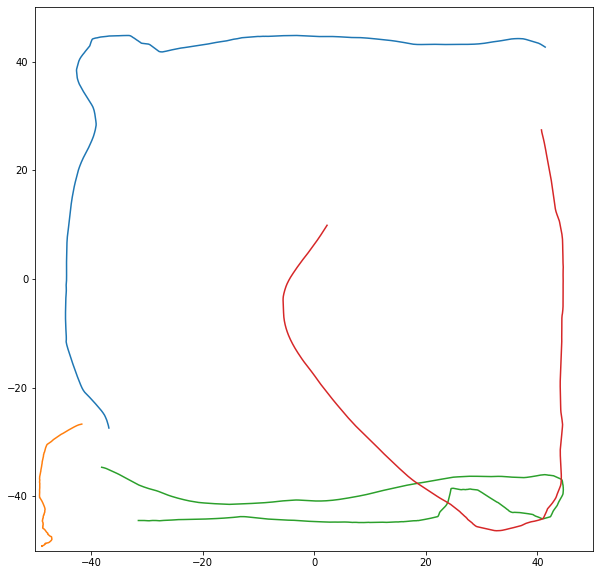

In [49]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [ ]:
import optuna
import pandas as pd
from sklearn import model_selection


In [ ]:
# Parameter with Optuna
#Step 1. Define an objective function to be maximized.
def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest"])
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = linear_model.LogisticRegression(C=logreg_c)
    else:
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators
        )

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)